# CYBER Master

This project is to process the data of recorded voices and baseline measurements for the attachment style interaction with depression and anxiety, in a sense this will work a the ETL or pre-processing of the data.

This notebook has a single purpose expressed in the following steps:
- Gather the answers from the survey DB
- Process the answers by uniques and present a report of the demographics, attachment styles and HADS answers
- From each answer, get the recordings from blob storage.
- For each recording transcribe them and associate them to the answer
- Store the resulting data in the DB for further analysis

In [2]:
# -*- coding: utf-8 -*-

# Import the necessary libraries
import os
import json
from datetime import datetime
from dotenv import load_dotenv, find_dotenv
import subprocess
import requests
from typing import List

load_dotenv(find_dotenv())

CONSENT_SURVEY_ID = "8"
STUDY_SURVEY_ID = "7"
OLLAMA_VERSION = "v0.8"

QUESTIONS = {
    "en": {
        "1": "What’s happening in the picture?",
        "2": "What led up to that scene?",
        "3": "What the characters are thinking or feeling?",
        "4": "What might happen next?",
    },
    "es": {
        "1": "¿Qué está pasando en la imagen?",
        "2": "¿Qué eventos llevaron a esta escena?",
        "3": "¿Qué están sintiendo o pensando los personajes?",
        "4": "¿Qué ocurrirá a continuación?",
    },
}

IMAGE_KEYS = [
    "Image 1 - 1",
    "Image 1 - 2",
    "Image 1 - 3",
    "Image 1 - 4",
    "Image 2 - 1",
    "Image 2 - 2",
    "Image 2 - 3",
    "Image 2 - 4",
    "Image 3 - 1",
    "Image 3 - 2",
    "Image 3 - 3",
    "Image 3 - 4",
    "Image 4 - 1",
    "Image 4 - 2",
    "Image 4 - 3",
    "Image 4 - 4",
    "Image 5 -1",
    "Image 5 - 2",
    "Image 5 - 3",
    "Image 5 - 4",
    "Image 6 - 1",
    "Image 6 - 2",
    "Image 6 - 3",
    "Image 6 - 4",
    "Image 7 - 1",
    "Image 7 - 2",
    "Image 7 - 3",
    "Image 7 - 4",
    "Image 8 - 1",
    "Image 8 - 2",
    "Image 8 - 3",
    "Image 8 - 4",
]


def transcribe_audio(file_path, language="en"):
    # Use the local vosk via CLI to get the transcription
    result_file = file_path.replace(".wav", ".txt")
    subprocess.run(
        [
            "vosk-transcriber",
            "-i",
            file_path,
            "-l",
            language,
            "-o",
            result_file,
            "--log-level",
            "INFO",
        ]
    )
    # Read the transcription
    with open(result_file, "r") as transcription_file:
        transcription = transcription_file.read()
        return transcription


def request_llm_analysis(prompts: List[str], language="en"):
    url = "http://localhost:11434/api/generate"
    prompt = (
        "No explanations or additional information should be included in the answer only the results, Consider only the following information."
    )
    prompt += " ".join(prompts)
    data = {
        "prompt": prompt,
        "model": OLLAMA_VERSION,
    }
    response = requests.post(url, json=data)
    result = ""
    for line in response.text.split("\n"):
        if '"done": true' in line or not line:
            return result
        else:
            try:
                result += json.loads(line)["response"]
            except Exception as e:
                print(e)
                print(line)
                continue


    return result


def score_HADS(answers: dict) -> tuple:
    anxiety_items = {
        "HADS 1": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 5": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 6": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 8": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 9": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 12": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 13": {"0": 3, "1": 2, "2": 1, "3": 0},
    }
    depression_items = {
        "HADS 2": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 3": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 4": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 7": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 10": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 11": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 14": {"0": 0, "1": 1, "2": 2, "3": 3},
    }

    anxiety_score = 0
    depression_score = 0

    for item, answer in answers.items():
        if item in anxiety_items:
            anxiety_score += anxiety_items[item][answer]
        elif item in depression_items:
            depression_score += depression_items[item][answer]

    return anxiety_score, depression_score


def score_RQ(answers: dict) -> dict:
    anxiety_score = 0
    avoidance_score = 0

    styles = {
        "A": "Secure",
        "B": "Fearful",
        "C": "Preoccupied",
        "D": "Dismissing",
    }

    results = {}
    for item, answer in answers.items():
        if item == "RQ1":
            results["style"] = styles[answer]
        elif item == "RQ2":
            anxiety_score += int(answer)
            avoidance_score += int(answer)
        elif item == "RQ3":
            anxiety_score -= int(answer)
            avoidance_score -= int(answer)
        elif item == "RQ4":
            anxiety_score -= int(answer)
            avoidance_score += int(answer)
        elif item == "RQ5":
            anxiety_score += int(answer)
            avoidance_score -= int(answer)

    results["anxiety"] = anxiety_score
    results["avoidance"] = avoidance_score
    return results

def get_only_numbers(text: str) -> str:
    return ''.join(filter(str.isdigit, text))

## Connect to the DB

In [3]:
import mysql.connector

connection = mysql.connector.connect(
    user=os.getenv("DB_USERNAME"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    port=os.getenv("DB_PORT"),
)
cursor = connection.cursor()

# query the answers table
query = (
    f"SELECT * FROM surveys_answer where surveys_answer.survey_id = {STUDY_SURVEY_ID}"
)
cursor.execute(query)
answers = cursor.fetchall()

In [4]:
# Parse the answers
json_answers = []

for answer in answers:
    dict_answer = json.loads(json.loads(answer[1]))
    if dict_answer.get("response-uuid") not in [
        answer.get("response-uuid") for answer in json_answers
    ]:
        json_answers.append({"id": answer[0], **json.loads(json.loads(answer[1]))})
    else:
        for json_answer in json_answers:
            if json_answer.get("response-uuid") == dict_answer.get("response-uuid"):
                json_answer.update(json.loads(json.loads(answer[1])))
                break

full_answers = [answer for answer in json_answers if len(answer.keys()) >= 62]
# get answers by language in a dictionary
answers_by_language = {}
answers_by_language = {
    "en": len([answer for answer in full_answers if answer["language"] == "en"]),
    "es": len([answer for answer in full_answers if answer["language"] == "es"]),
    "pt": len([answer for answer in full_answers if answer["language"] == "pt"]),
}
print(answers_by_language)

{'en': 34, 'es': 11, 'pt': 0}


In [109]:
# Get the recording info from the recording table
recordings_query = f"SELECT * FROM surveys_recording"  # where surveys_recording.answer_id in ({','.join([str(answer.get('id')) for answer in full_answers])})"
cursor.execute(recordings_query)
recordings = cursor.fetchall()

In [110]:
for answer in full_answers:
    for recording in recordings:
        for key, value in answer.items():
            if not isinstance(value, str) or len(value) < 4:
                continue
            if value.replace("-", "") != recording[-1]:
                continue
            answer[key] = f"{recording[1].replace('recordings/', '')}.wav"


print(full_answers[-1])

{'id': 1637, 'language': 'en', 'response-uuid': '685dcc76-1155-4a62-be19-bb14237e0e2e', 'Demographic - Age': '53', 'Demographic - Gender': 'female', 'Demographic - Education level': 'master', 'Demographic - Relationship status': 'married', 'Demographic - Native speaker': 'yes', 'Demographic - speech diagnosis': 'no', 'Demographic - psychiatric disorder': 'no', 'Demographic - Substances': 'no', 'RQ1': 'D', 'RQ2': '2', 'RQ3': '5', 'RQ4': '2', 'RQ5': '6', 'HADS 1': '2', 'HADS 2': '1', 'HADS 3': '1', 'HADS 4': '2', 'HADS 5': '2', 'HADS 6': '2', 'HADS 7': '2', 'HADS 8': '1', 'HADS 9': '2', 'HADS 10': '2', 'HADS 11': '2', 'HADS 12': '1', 'HADS 13': '2', 'HADS 14': '3', 'Image 1 - 1': 'blob_XiPbp0m.wav', 'Image 1 - 2': 'blob_rCmhBkc.wav', 'Image 1 - 3': 'blob_TEheDwj.wav', 'Image 1 - 4': 'blob_RFUXLHT.wav', 'Image 2 - 1': 'blob_P4OfM8P.wav', 'Image 2 - 2': 'blob_DeLAUSZ.wav', 'Image 2 - 3': 'blob_m5yD4Ll.wav', 'Image 2 - 4': 'blob_8tetmdt.wav', 'Image 3 - 1': 'blob_14fU11h.wav', 'Image 3 - 2'

## Getting the recordings per answer

In [111]:
from azure.storage.blob import BlobServiceClient

CONTAINER_NAME = "recordings"

blob_service = BlobServiceClient.from_connection_string(
    os.getenv("AZURE_CONNECTION_STRING")
)
local_path = "./recordings"
# create the folder if not alrady
if not os.path.exists(local_path):
    os.mkdir(local_path)

# Sanity check, listing the blobs in the container
container_client = blob_service.get_container_client(CONTAINER_NAME)
blob_list = []
for blob in container_client.list_blobs():
    if "blob" in blob.name:
        blob_list.append(blob.name)

In [112]:
# Download the blobs into the recordings folder if not already downloaded
for blob in blob_list:
    result_file_name = blob.split("/")[-1]
    result_file_name = f"{result_file_name}.wav"
    if result_file_name not in os.listdir(local_path):
        with open(file=f"{local_path}/{result_file_name}", mode="wb") as audio_file:
            download_stream = container_client.download_blob(blob)
            audio_file.write(download_stream.readall())

# list all the files in the folder
files = os.listdir(local_path)
print(len(files))

2961


## Vosk

We are using [vosk](https://alphacephei.com/vosk/) to transcribe the audio into text, then assign it to the answer for further processing

In [113]:
for answer in full_answers:
    for key, value in answer.items():
        if not isinstance(value, str) or not value.endswith(".wav"):
            continue
        if value not in files:
            print(f"File {value} not found")
            continue
        if value.replace(".wav", ".txt") in os.listdir(local_path):
            print(f"File {value} already transcribed")
            answer[key] = open(
                f"{local_path}/{value.replace('.wav', '.txt')}", "r"
            ).read()
            continue
        answer[key] = transcribe_audio(
            f"{local_path}/{value}", language=answer["language"]
        )

File blob_nrnej2h.wav already transcribed
File blob_6Pu57EX.wav already transcribed
File blob_DSHsnaO.wav already transcribed
File blob_tLTvyIY.wav already transcribed
File blob_oQmoc6K.wav already transcribed
File blob_wVigQOC.wav already transcribed
File blob_81DcWTq.wav already transcribed
File blob_yiLAcqi.wav already transcribed
File blob_2ZzcIQ2.wav already transcribed
File blob_ijGVE3a.wav already transcribed
File blob_9nF4u9E.wav already transcribed
File blob_Kemd4qU.wav already transcribed
File blob_rbSy8qO.wav already transcribed
File blob_7J4aQii.wav already transcribed
File blob_PmIsMAa.wav already transcribed
File blob_hh9HFZm.wav already transcribed
File blob_7oAe8QB.wav already transcribed
File blob_V6S1D46.wav already transcribed
File blob_Pbfp6Ij.wav already transcribed
File blob_ttmhOBh.wav already transcribed
File blob_fpWJDLo.wav already transcribed
File blob_hmRuNX3.wav already transcribed
File blob_KRBmVTH.wav already transcribed
File blob_7tnXxx6.wav already tran

In [114]:
for answer in full_answers:
    for key, value in answer.items():
        if not isinstance(value, str) or not value.endswith(".wav"):
            continue
        if value not in files:
            print(f"File {value} not found")
            continue
        if value.replace(".wav", ".txt") in os.listdir(local_path):
            print(f"File {value} already transcribed")
            answer[key] = open(
                f"{local_path}/{value.replace('.wav', '.txt')}", "r"
            ).read()
            continue
        answer[key] = transcribe_audio(
            f"{local_path}/{value}", language=answer["language"]
        )

## Scoring the validated scales

We are using the HADS and RQ scales to determine the anxiety and depression, and the attachment style status accordingly.

### HADS - Hospital Anxiety and Depression Scale
A self report tool developed in 1983 by [Zigmond and Snaith](https://pubmed.ncbi.nlm.nih.gov/6880820/). It allows a dimensional scoring of the status of the patient and allows the better understanding of the psychiatric and psychological needs of a hospital patient.

The scale is composed of 14 items in a 4-item likert scale pointed from 0 to 3 and dedicates 7 items to depression and anxiety respectively. The scoring occurs by aggregating the values of each item and group, therefore, distributed as follows:
- Scores 0 to 7: Normal
- Scores 8 to 10: Borderline abnormal (at risk(?))
- Scores 11 - 21:  Abnormal (Usually requires a proper diagnosis and treatment)


### RQ - The Relationship Questionnaire
A self report questionnaire developed in 1991 by [Bartholomew & Horowitz](https://pubmed.ncbi.nlm.nih.gov/1920064/) composed of two segments with the objective of measuring the adult attachment styles. the styles are defined on two axis: Avoidance and anxiety.
The avoidance axis refers to the internal model of others and the anxiety to the internal model of self and usually presented as a cartesian plane, in which an adult may have a combination of both axis.
The four general cartesian regions in the adult attachment are:
**Secure**: Low avoidance - Low anxiety: The person considers others and themselves as trustworthy.
**Preoccupied**: Low avoidance - High anxiety: The person considers others are more trustworthy and generate a dependency due to internal low self-worth.
**Dismissing**: High avoidance - Low anxiety: The person has low trust on others but is self-reliant (opossite to the one above).
**Fearful**: High avoidance - High anxiety: The person does not trust others and has low self worth.

In this scale a person will first select a paragraph that reflects directly one of the styles above, then rates the agreement with each style prototype in a 7-item likert scales. From the answers in the likert scales the values on both axis are extracted and calculated as follows:
- **Model of self**: (secure + dissmissing) - (preocupied + fearful)
- **Model of others**: (secure + preocupied) - (dissmissing + fearful)

In [115]:
# Score HADS and RQ from the full_answers
for answer in full_answers:
    answer["HADS score - Anxiety"], answer["HADS score - Depression"] = score_HADS({f"HADS {i}": answer.get(f"HADS {i}") for i in range(1, 15)})
    answer["RQ score"] = score_RQ({f"RQ{i}": answer.get(f"RQ{i}") for i in range(1, 6)})


## Invoquing OLlama model using the prompts

The audio tracks were transcribed and will be fed in a custom prompt to a local Llama2 model using the [OLlama framework](https://ollama.com/)([Git hub documentation](https://github.com/ollama/ollama)).

The model has been pretrained by setting the `seed`, to ensure more deterministic results, and with a preparation prompt with extra instructions. The model is asked to act as a psiquiatrist assistant and given some context about the attachment styles, following the best practices mentioned in the literature ([1](https://arxiv.org/abs/2309.09128), [2](https://www.jmir.org/2023/1/e50638/), [3](https://link.springer.com/chapter/10.1007/978-981-99-7962-2_30)) The prompts and settings used in setup are available in the file `Modelfile` in this repository.


Then for each participant we agreggate all answers to the images and ask the model to determine the attachment style and two percentages for anxiety and depression afterwards.

In [116]:
# prepare the prompt to be fed to the LLM
for answer in full_answers:
    answer["prompts"] = []
    for key in IMAGE_KEYS:
        if answer.get(key) is None:
            continue
        answer.get("prompts").append(
            f"{key[0:8]} - {QUESTIONS.get(answer.get('language')).get(key[-1])} {answer[key]}"
        )

In [117]:
# request the LLM analysis

for answer in full_answers:
    answer["llm"] = []
    answer["llm_attachment_style"] = []
    answer["llm_anxiety"] = []
    answer["llm_depression"] = []
    for prompt in answer.get("prompts"):
        llm_answer = request_llm_analysis([prompt], language=answer.get("language"))
        answer.get("llm").append(llm_answer)
        # find the attachment style, anxiety and depression scores by getting the index of the prompt
        llm_answer = llm_answer.lower()
        print(llm_answer)
        # for aux_answer in llm_answer.split(","):
        #     split_ans = aux_answer.split()
        #     if "attachment style" in aux_answer:
        #         style_name = "insecure" if "insecure" in aux_answer else "secure"
        #         answer.get("llm_attachment_style").append(style_name)
        #     if "anxiety:" in aux_answer:
        #         index = split_ans.index("anxiety:")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_anxiety").append(score)
        #     elif "anxiety" in aux_answer:
        #         index = split_ans.index("anxiety")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_anxiety").append(score)
        #     else:
        #         answer.get("llm_anxiety").append(None)
        #     if "depression:" in aux_answer:
        #         index = split_ans.index("depression:")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_depression").append(score)
        #     elif "depression" in aux_answer:
        #         index = split_ans.index("depression")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_depression").append(score)
        #     else:
        #         answer.get("llm_depression").append(None)

attachment style: secure, anxiety: 0, depression: 0
attachment style: secure, anxiety: 50, depression: 30

attachment style: insecure, anxiety: 75, depression: 40

attachment style: secure, anxiety: 25, depression: 15

attachment style: insecure, anxiety: 90, depression: 60
attachment style: secure, anxiety: 0, depression: 0.

attachment style: insecure, anxiety: 80, depression: 60.

attachment style: secure, anxiety: 0, depression: 0.
attachment style: insecure, anxiety: 40, depression: 30.

attachment style: secure, anxiety: 0, depression: 0.
attachment style: secure, anxiety: 0, depression: 0
attachment style: secure, anxiety: 0, depression: 0
attachment style: secure, anxiety: 50, depression: 30
attachment style: secure, anxiety: 30, depression: 20

attachment style: insecure, anxiety: 60, depression: 40

attachment style: secure, anxiety: 10, depression: 0

attachment style: insecure, anxiety: 80, depression: 60
attachment style: secure, anxiety: 0, depression: 0.
attachment style

## Store the resulting data

In [118]:
# save the answers in a json lines file
now_date = datetime.now().strftime("%Y-%m-%d--%H-%M")
with open(f"raw_answers-{now_date}.json", "w") as answers_file:
    answers_file.write(json.dumps(full_answers, indent=4))

## Final data preparation

***Note:*** Due to LLM allucination and result rendering, the data has a manual segment under the key `curated_llm` which is a cleanup of the data in `llm` (the original answer from the model) keeping exclusively the first segment of the answer holding the relevant data., this is subjected to the data separation mentioned in this section.


In order to compare the results from RQ, HADS and the LLM data we need to transform the data from the LLM:
* __Attachment style:__ We want to report a percentage of each style to present from the amount of times one style is mentioned in the list.
* __Anxiety and Depression:__ An average value from the reported values may allow to compare to HADS.

We want to address two specific questions:
- Which image has more accurate information about attachment, anxiety, and depression.
- Which question (1, 2, 3, 4) in all images is more accurate as well.

In order to answer those questions the data should be grouped per image and per question to gather the average and compare

In [5]:
# Load the answers from the json lines file
with open(f"raw_answers-2024-05-27--20-23.json", "r") as answers_file:
    full_answers = json.load(answers_file)

In [6]:
# Split the information of attachment style, anxiety and depression scores
for answer in full_answers:
    answer["llm_attachment_style"] = []
    answer["llm_anxiety"] = []
    answer["llm_depression"] = []
    for llm_data in answer.get("curated_llm"):
        lower_llm_data = llm_data.lower()
        split_ans = lower_llm_data.lower().split()
        if "attachment style" in lower_llm_data:
            style_name = "insecure" if "insecure" in lower_llm_data else "secure"
            answer.get("llm_attachment_style").append(style_name)
        if "anxiety:" in lower_llm_data:
            index = split_ans.index("anxiety:")
            score = get_only_numbers(split_ans[index + 1])
            answer.get("llm_anxiety").append(score)
        if "depression:" in lower_llm_data:
            index = split_ans.index("depression:")
            try:
                score = get_only_numbers(split_ans[index + 1])
            except Exception as e:
                print(e)
                print(split_ans)
                print(answer)
                continue

            answer.get("llm_depression").append(score)

In [38]:
from typing import Tuple, Optional

def get_styles_percentage(styles: list, percentages: bool = False) -> Tuple[str, Optional[dict]]:
    result = {}
    total = len(styles)
    for style in styles:
        if style not in result:
            result[style] = styles.count(style)
    style = max(result, key=result.get)
    if percentages:
        return style, {key: value / total for key, value in result.items()}
    return style
    

def get_scores_average(scores: list[int]) -> float:
    return sum(scores) / len(scores)

In [40]:

for answer in full_answers:
    # get the llm_attachment_style, llm_anxiety, llm_depression
    llm_attachment_style = answer.get("llm_attachment_style")
    llm_anxiety = answer.get("llm_anxiety")
    llm_depression = answer.get("llm_depression")
    if not llm_attachment_style:
        print(answer)
        continue
    # calculate the average of the llm_anxiety and llm_depression
    anxiety_aux = [int(i) for i in llm_anxiety if i is not None]
    llm_anxiety_average = sum(anxiety_aux) / len(anxiety_aux) if len(anxiety_aux) > 0 else None
    depression_aux = [int(i) for i in llm_depression if i is not None]
    llm_depression_average = sum(depression_aux) / len(depression_aux) if len(depression_aux) > 0 else None
    answer["llm_anxiety_average"] = llm_anxiety_average
    answer["llm_depression_average"] = llm_depression_average
    # get the amount of times the attachment style was mentioned
    # attachment_styles_aux = {}
    # for style in llm_attachment_style:
    #     if style in attachment_styles_aux:
    #         attachment_styles_aux[style] += 1
    #     else:
    #         attachment_styles_aux[style] = 1
    # # get the percentage of the attachment styles
    # total = sum(attachment_styles_aux.values())
    # attachment_styles = {k: v / total for k, v in attachment_styles_aux.items()}
    answer["llm_attachment_styles_percentages"] = get_styles_percentage(llm_attachment_style)



Split the answers by Image:

In [41]:
for answer in full_answers:
    for img_num in range(1, 9):
        answer[f"image_{img_num}_llm_style"] = get_styles_percentage(answer.get("llm_attachment_style")[img_num - 1: img_num + 3])
        answer[f"image_{img_num}_llm_anxiety"] = get_scores_average([int(_) for _ in answer.get("llm_anxiety")[img_num - 1: img_num + 3]])
        answer[f"image_{img_num}_llm_depression"] = get_scores_average([int(_) for _ in answer.get("llm_depression")[img_num - 1: img_num + 3]])


Split the answers by question: Description, Past, Present, Future

In [42]:
description_index = [0, 4, 8, 12, 16, 20, 24, 28]
past_index = [1, 5, 9, 13, 17, 21, 25, 29]
present_index = [2, 6, 10, 14, 18, 22, 26, 30]
future_index = [3, 7, 11, 15, 19, 23, 27, 31]

for answer in full_answers:
    answer["description_llm_style"] = get_styles_percentage([answer.get("llm_attachment_style")[i] for i in description_index])
    answer["description_llm_anxiety"] = get_scores_average([int(answer.get("llm_anxiety")[i]) for i in description_index])
    answer["description_llm_depression"] = get_scores_average([int(answer.get("llm_depression")[i]) for i in description_index])
    answer["past_llm_style"] = get_styles_percentage([answer.get("llm_attachment_style")[i] for i in past_index])
    answer["past_llm_anxiety"] = get_scores_average([int(answer.get("llm_anxiety")[i]) for i in past_index])
    answer["past_llm_depression"] = get_scores_average([int(answer.get("llm_depression")[i]) for i in past_index])
    answer["present_llm_style"] = get_styles_percentage([answer.get("llm_attachment_style")[i] for i in present_index])
    answer["present_llm_anxiety"] = get_scores_average([int(answer.get("llm_anxiety")[i]) for i in present_index])
    answer["present_llm_depression"] = get_scores_average([int(answer.get("llm_depression")[i]) for i in present_index])
    answer["future_llm_style"] = get_styles_percentage([answer.get("llm_attachment_style")[i] for i in future_index])
    answer["future_llm_anxiety"] = get_scores_average([int(answer.get("llm_anxiety")[i]) for i in future_index])
    answer["future_llm_depression"] = get_scores_average([int(answer.get("llm_depression")[i]) for i in future_index])


In [43]:
# save the answers in a json lines file
now_date = datetime.now().strftime("%Y-%m-%d--%H-%M")
with open(f"answers-{now_date}.json", "w") as answers_file:
    answers_file.write(json.dumps(full_answers, indent=4))

## Data analysis

We will start doing a simple exploratory analysis of the data, checking the amount of people and the distribution of the demographic data gathered from the surveys.
Then we will compare the results got from the HADS and RQ to the results from the LLM.

In [24]:
# Add the information into a Dataframe
import pandas as pd

df = pd.DataFrame(full_answers)
# describe the dataframe to get the statistics
# check only for the columns with the 'Demographic - ' prefix
demographics = df[
    [col for col in df.columns if col.startswith("Demographic - ")]
]
demographics.describe()

,Demographic - Age,Demographic - Gender,Demographic - Education level,Demographic - Relationship status,Demographic - Native speaker,Demographic - speech diagnosis,Demographic - psychiatric disorder,Demographic - Substances
count,45,45,45,45,45,45,45,45
unique,31,2,4,4,1,1,1,1
top,26,female,bachelor,married,yes,no,no,no
freq,5,25,18,17,45,45,45,45


In [25]:
demographics["Demographic - Gender"].value_counts()

Demographic - Gender
female    25
male      20
Name: count, dtype: int64

59 19


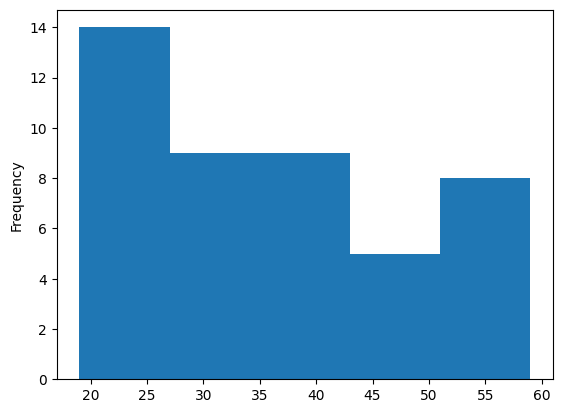

In [37]:
# Get the max and min age
print(demographics["Demographic - Age"].max(), demographics["Demographic - Age"].min())

# graph and histogram of the ages
import matplotlib.pyplot as plt

demographics["Demographic - Age"].astype(int).plot.hist(bins=5)

plt.show()


In [160]:
# get HADS scores and llm depression and anxiety averages
df["llm_depression_average"] = df["llm_depression_average"].apply(
    lambda x: int(x) if x is not None else None
)
df["llm_anxiety_average"] = df["llm_anxiety_average"].apply(
    lambda x: int(x) if x is not None else None
)

# print the columns with the HADS score and the llm depression and anxiety averages as a table
print(
    df[
        [
            "HADS score - Anxiety",
            "HADS score - Depression",
            "llm_depression_average",
            "llm_anxiety_average",
        ]
    ]
)


    HADS score - Anxiety  HADS score - Depression  llm_depression_average  \
0                      4                        6                      12   
1                      7                        7                       5   
2                      6                        8                      26   
3                      2                        5                      16   
4                      4                        7                       8   
5                      5                        6                      21   
6                      4                        6                      15   
7                      1                        9                      12   
8                      3                        6                       0   
9                      2                        4                      14   
10                     8                        8                      12   
11                    10                        5                       0   